# Autoencoder for MNIST compared to supervised model

### Imports and load the MNIST dataset into train, validation and test sets

In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Supervised split
supervised_split = 0.01
train_split = 0.8

# Data where labels are available
supervised_images = x_train[:int(supervised_split * len(x_train))]
supervised_labels = y_train[:int(supervised_split * len(y_train))]

# Data where labels are not available
unsupervised_images = x_train[int(supervised_split * len(x_train)):]
unsupervised_labels = y_train[int(supervised_split * len(y_train)):]

# Split both supervised and unsupervised data into train and validation
supervised_train_images = supervised_images[:int(train_split * len(supervised_images))]
supervised_train_labels = supervised_labels[:int(train_split * len(supervised_labels))]
supervised_val_images = supervised_images[int(train_split * len(supervised_images)):]
supervised_val_labels = supervised_labels[int(train_split * len(supervised_labels)):]

unsupervised_val_images = unsupervised_images[:int(train_split * len(unsupervised_images))]
unsupervised_val_images = unsupervised_images[int(train_split * len(unsupervised_images)):]

unsupervised_val_labels = unsupervised_labels[int(train_split * len(unsupervised_labels)):]

# Exstract input shape
input_shape = x_train.shape[1:] # (28, 28)

print(f"Supervised train images shape: {supervised_train_images.shape}")
print(f"Supervised train labels shape: {supervised_train_labels.shape}")
print(f"Supervised val images shape: {supervised_val_images.shape}")
print(f"Supervised val labels shape: {supervised_val_labels.shape}")
print(f"Unsupervised train images shape: {unsupervised_val_images.shape}")
print(f"Unsupervised val images shape: {unsupervised_val_images.shape}")

print(f'Test images shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')


Supervised train images shape: (480, 28, 28)
Supervised train labels shape: (480,)
Supervised val images shape: (120, 28, 28)
Supervised val labels shape: (120,)
Unsupervised train images shape: (11880, 28, 28)
Unsupervised val images shape: (11880, 28, 28)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


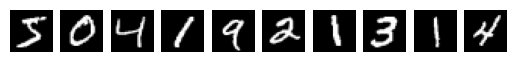

In [54]:
# Plot the first 10 images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

In [55]:
# Add noise to the images
noise_factor = 0.3
x_train_noise = unsupervised_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=unsupervised_images.shape)
x_test_noise = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

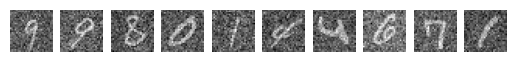

In [403]:
# Print the same 10 images with noise
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_noise[i], cmap='gray')
    plt.axis('off')

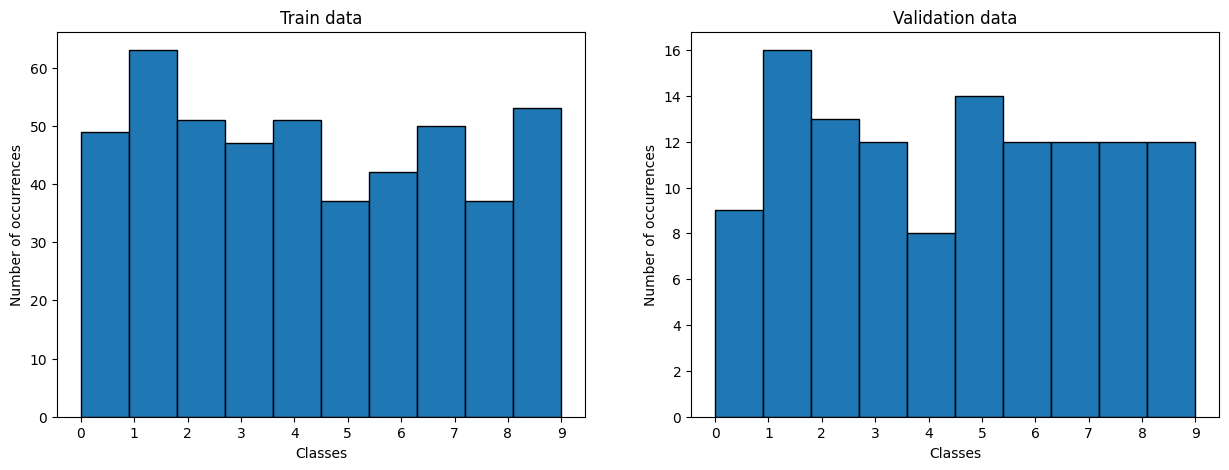

In [56]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
axs[0].hist(supervised_train_labels, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes') 
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(supervised_val_labels, ec='black')
axs[1].set_title('Validation data')
axs[1].set_xlabel('Classes') 
axs[1].set_ylabel('Number of occurrences')
# We want to show all ticks...
axs[0].set_xticks(np.arange(10))
axs[1].set_xticks(np.arange(10))

plt.show()

### Vector size for latent variables and number of epochs

In [57]:
LATENT_SIZE = 32
EPOCHS_UNSUPERVISED = 100
EPOCHS_SUPERVISED = 100

### Define the autoencoder model consisting of an encoder and decoder

In [58]:
# Autoencoder using Dense layers
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(784, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu")
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(784, activation="sigmoid"),
    tf.keras.layers.Reshape(input_shape)
])

img = tf.keras.layers.Input(shape = input_shape)
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = tf.keras.models.Model(inputs = img, outputs = output)

encoder_weights_before_pre_train = encoder.get_weights()

### Compile and train the autoencoder

In [59]:
autoencoder.compile("adam", loss="mean_squared_error")

autoencoder.summary()

history = autoencoder.fit(unsupervised_images,
                          unsupervised_images,
                          epochs=EPOCHS_UNSUPERVISED,
                          shuffle=True,
                          validation_data=(
                              unsupervised_val_images, unsupervised_val_images)
                          )

# Get the weights of the encoder in the autoencoder after pre-training
encoder_weights_after_pre_train = autoencoder.layers[1].get_weights()

assert not np.array_equal(encoder_weights_before_pre_train[0], encoder_weights_after_pre_train[0]
                          ), "The weights of the encoder have not changed after pre-training"

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 sequential_37 (Sequential)  (None, 32)                726256    
                                                                 
 sequential_38 (Sequential)  (None, 28, 28)            111568    
                                                                 
Total params: 837,824
Trainable params: 837,824
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1857/1857 [==============================] - 13s 6ms/step - loss: 0.0282 - val_loss: 0.0176
Epoch 2/100
1857/1857 [==============================] - 12s 6ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 3/100
1857/1857 [==============================] - 12s 6ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch

Original images


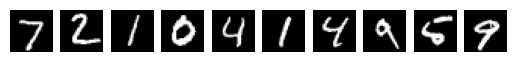

Reconstructed images


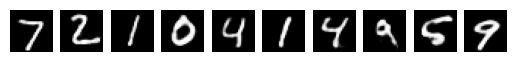

In [187]:
# Plot the 10 first images in the test set
print("Original images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')
plt.show()


# Predict the first 10 images for the test set
predicted = autoencoder.predict(x_test[:10], verbose=0)

print("Reconstructed images")

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(predicted[i], cmap='gray')
    plt.axis('off')
plt.show()

### Plot the autoencoder loss

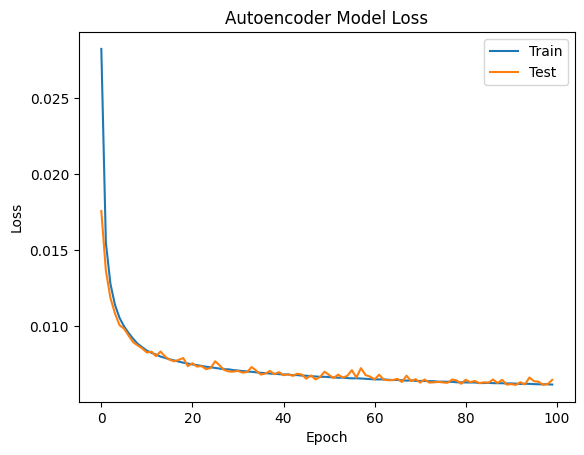

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [66]:
# Save the encoder part of the autoencoder
autoencoder.save('../models/autoencoder.h5')

### Fine-tune the model with supervised learning with 10% of the training data

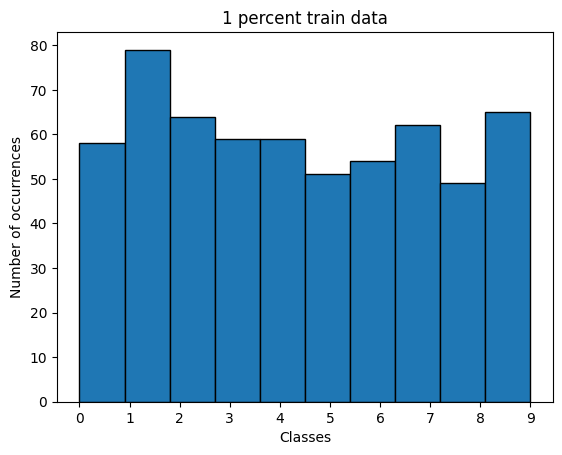

In [183]:
plt.plot(figsize=(10,5)) 
plt.hist(supervised_labels, ec='black')
plt.title('1 percent train data')
plt.xlabel('Classes') 
plt.ylabel('Number of occurrences')
plt.xticks(np.arange(10))
plt.show()

In [172]:
# Get the saved encoder
LOAD = True

if LOAD:
    autoencoder_copy = tf.keras.models.load_model('../models/autoencoder.h5')
else:
    # Make a copy of the autoencoder
    autoencoder_copy = tf.keras.models.clone_model(autoencoder)

encoder = autoencoder_copy.layers[1]

# Set up the model
fine_tune_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

fine_tune_model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

# Compile the model
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history_autoencoder = fine_tune_model.fit(
    supervised_train_images,
    supervised_train_labels,
    validation_data=(supervised_val_images, supervised_val_labels),
    epochs=EPOCHS_SUPERVISED,
    verbose=2,
    batch_size=10,
    callbacks=[callback]
)

# Evaluate the model on the test set
res_unsupervised = fine_tune_model.evaluate(x_test, y_test)
print(f"Loss, Accuracy after fine-tuning: {res_unsupervised}")

Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_37 (Sequential)  (None, 32)                726256    
                                                                 
 dense_327 (Dense)           (None, 256)               8448      
                                                                 
 dense_328 (Dense)           (None, 128)               32896     
                                                                 
 dense_329 (Dense)           (None, 10)                1290      
                                                                 
Total params: 768,890
Trainable params: 768,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 - 1s - loss: 1.4204 - accuracy: 0.6021 - val_loss: 0.9867 - val_accuracy: 0.6500 - 1s/epoch - 29ms/step
Epoch 2/100
48/48 - 0s - loss: 0.3615 - accuracy: 0.8917

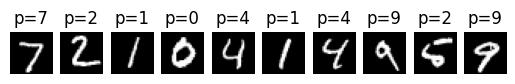

In [182]:
# Predict some images from the test set
predicted = fine_tune_model.predict(x_test[:10], verbose=0)

for i in range(10):
    plt.subplot(1, 10, i+1, title=f'p={np.argmax(predicted[i])}')
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

## Training a FNN model supervised on 1% of the labeled data

In [176]:
# Set up the model using dense layers
supervised_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(784, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
supervised_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

# Train the model
history_supervised = supervised_model.fit(
    supervised_train_images,
    supervised_train_labels,
    validation_data=(supervised_val_images, supervised_val_labels),
    epochs=EPOCHS_SUPERVISED,
    verbose=2,
    callbacks=[callback]
)

# Evaluate the model on the test set
res_supervised = supervised_model.evaluate(x_test, y_test, verbose=0)
print(f"Loss, Accuracy : {res_supervised}")

Epoch 1/100
15/15 - 1s - loss: 1.4417 - accuracy: 0.5875 - val_loss: 0.9733 - val_accuracy: 0.7083 - 856ms/epoch - 57ms/step
Epoch 2/100
15/15 - 0s - loss: 0.4715 - accuracy: 0.8458 - val_loss: 0.7923 - val_accuracy: 0.7667 - 137ms/epoch - 9ms/step
Epoch 3/100
15/15 - 0s - loss: 0.2229 - accuracy: 0.9271 - val_loss: 0.8073 - val_accuracy: 0.7417 - 137ms/epoch - 9ms/step
Epoch 4/100
15/15 - 0s - loss: 0.1018 - accuracy: 0.9854 - val_loss: 0.8992 - val_accuracy: 0.7417 - 144ms/epoch - 10ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0562 - accuracy: 0.9896 - val_loss: 0.8209 - val_accuracy: 0.7750 - 144ms/epoch - 10ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0282 - accuracy: 0.9979 - val_loss: 0.8616 - val_accuracy: 0.7333 - 143ms/epoch - 10ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.7222 - val_accuracy: 0.7833 - 145ms/epoch - 10ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.7558 - val_accuracy: 0.8000 - 138ms/epoch - 9ms/step
Epo

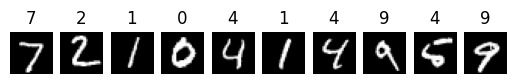

In [177]:
# Predict some images from the test set
predicted = supervised_model.predict(x_test[:10], verbose=0)

for i in range(10):
    # Image title is the predicted class
    plt.subplot(1, 10, i+1, title=np.argmax(predicted[i]))
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

In [178]:
# Save the model
supervised_model.save('../models/supervised_model.h5')

### Plot the history accuracy of the two models

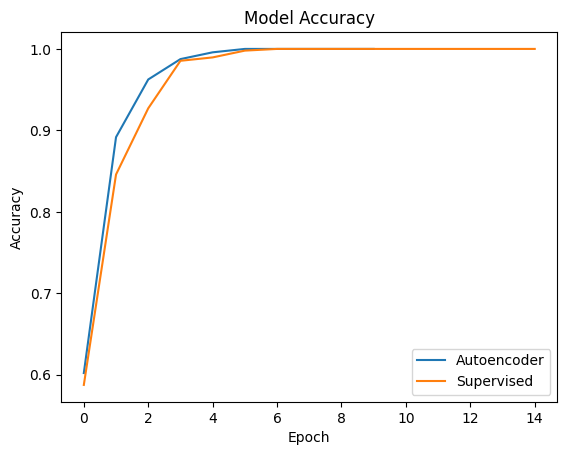

In [179]:
plt.plot(history_autoencoder.history['accuracy'])
plt.plot(history_supervised.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Supervised'], loc='lower right')
plt.show()

### Compare the performance of the autoencoder and FNN models

In [180]:
print(f'Unsupervised pre-trained FNN autoencoder with supervised fine-tuning accuracy: {res_unsupervised[1]}')
print(f'Supervised FNN accuracy: {res_supervised[1]}')
print()

# Get the absolute difference between the two models
diff = abs(res_unsupervised[1] - res_supervised[1])
# Get percentage difference
diff = diff / res_supervised[1] * 100
# Round to 2 decimals
diff = round(diff, 2)

if res_unsupervised[1] > res_supervised[1]:
    print(f'Unsupervised pre-trained autoencoder with supervised 1% labels fine-tuning performs better by {diff}%')
else:
    print(f'Supervised classifier with 1% labels is better by {diff} percent')

Unsupervised pre-trained FNN autoencoder with supervised fine-tuning accuracy: 0.8730000257492065
Supervised FNN accuracy: 0.8485000133514404

Unsupervised pre-trained autoencoder with supervised 1% labels fine-tuning performs better by 2.89%


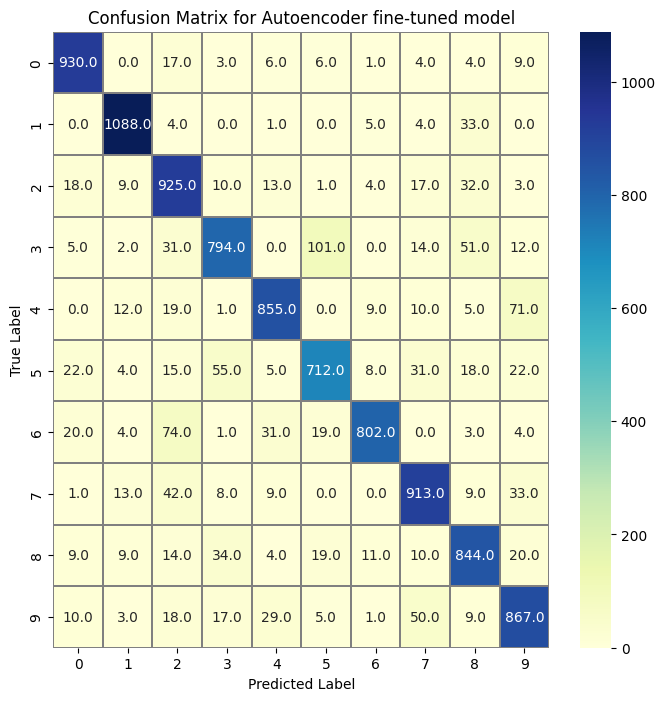

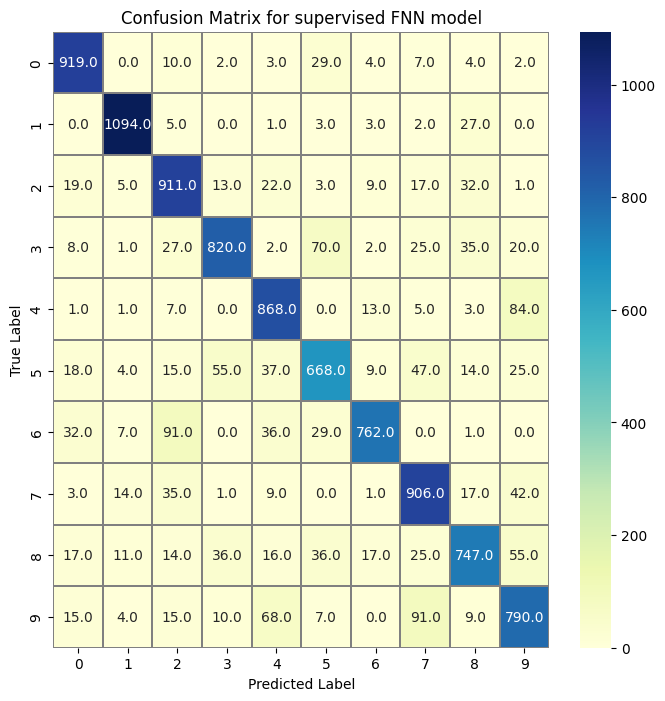

In [181]:
# Seaborn heatmap of confusion matrix

# Predict the values from the validation dataset
Y_pred = fine_tune_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Autoencoder fine-tuned model")


# Predict the values from the validation dataset
Y_pred = supervised_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for supervised FNN model")
plt.show()